In [1]:
import keras
import quandl
import numpy as np

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

import keras.backend as K
from sklearn.model_selection import KFold

%matplotlib inline

Using TensorFlow backend.


In [2]:
#data = quandl.get('BCHARTS/BITFINEXUSD') -> OLD BUGGY DATASET (OBD)
data = quandl.get('BITFINEX/BTCUSD')
#data = quandl.get('BITFINEX/XRPBTC')
#data = quandl.get('BITFINEX/ETHBTC')

In [3]:
data.head()

,High,Low,Mid,Last,Bid,Ask,Volume
Date,,,,,,,
2014-04-15,513.9000,452.00,504.23500,505.0000,503.5000,504.97,21013.584774
2014-04-16,547.0000,495.00,537.50000,538.0000,537.0000,538.00,29633.358705
2014-04-17,538.5000,486.10,507.02000,508.0000,506.0400,508.00,20709.783819
2014-04-18,509.0000,474.25,483.77000,482.7500,482.7500,484.79,10458.045243
2014-04-19,513.9899,473.83,505.01065,507.4999,502.5313,507.49,8963.618369


In [4]:
print("data shape before embedding:",data.shape)

mean = data.mean(axis=0)
std = data.std(axis=0)

# zscore normalization
data = ( data - mean ) / std

# # of days past we want skynet to see
d = 15

X = np.zeros((data.shape[0],d,data.shape[1]))

# embedding d days in each DP (deslocamento)
for i in range(d,data.shape[0]):
    X[i,:,:] = data.iloc[i-d:i].values

#removing first d lines, this ones didn't have d days past
X = X[d:,:,:]

print("data shape after embedding:",X.shape)

data shape before embedding: (1336, 7)
data shape after embedding: (1321, 15, 7)


In [5]:
# creating labels
Y = data['Mid'] - data.shift(1)['Mid']

Y = Y > 0

Y.shape

(1336,)

In [6]:
#removing first line: second label refers to first DP ($$ delta)
Y = Y[1:]

#removing first d days because of the embedding
Y = Y[d:]

In [7]:
#removing last registry from X, since we had to remove first DP from Y
#specifying other dimensions for good practices - TY @lucasosouza
X = X[: -1,:,:]

In [8]:
# checking shapes
Y.shape, X.shape

((1320,), (1320, 15, 7))

In [9]:
# Adding channel layer, as expected by the convnet
X = X.reshape((Y.shape[0],d,7,1))
X.shape

(1320, 15, 7, 1)

In [10]:
# train / test split
#X_train = X[:-300,:,:,:]
#X_test = X[-300:,:,:,:]
#Y_train = Y[:-300]
#Y_test = Y[-300:]

# split dat data 
kf = KFold(n_splits=8,shuffle=True,random_state=0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    #print("TRAIN:", train_index, "TEST:", test_index)

In [11]:
def model(input_shape):
    
    X_input = Input(input_shape)
    
    #padding same so we dont lose size
    X = Conv2D(32,(3,3), strides=(1,1),name="conv0", padding="same")(X_input)
    X = BatchNormalization(axis=3,name='bn0')(X)
    X = Activation('relu')(X)

    #X = MaxPooling2D((2,2),name='max_pool0')(X)
    
    #Second conv
    X = Conv2D(64,(2,2), strides=(1,1),name="conv1", padding="same")(X)
    X = BatchNormalization(axis=3,name='bn1')(X)
    X = Activation('relu')(X)

    #X = MaxPooling2D((2,2),name='max_pool1')(X)
    
    #Third conv
    X = Conv2D(128,(1,1), strides=(1,1),name="conv2", padding="same")(X)
    X = BatchNormalization(axis=3,name='bn2')(X)
    X = Activation('relu')(X)
    
    #fcs
    X = Flatten()(X)
    X = Dense(128,activation="relu")(X)
    X = Dropout(rate=0.3, seed=0)(X)
    X = Dense(64,activation="relu")(X)
    #X = Dropout(rate=0.3, seed=0)(X)
    X = Dense(32,activation="relu")(X)
    #X = Dropout(rate=0.3, seed=0)(X)
    X = Dense(1,activation="sigmoid")(X)
    
    model = Model(inputs=X_input,outputs=X, name="model1")
    
    return model

In [12]:
#training the model, time for witchcraft
model = model(X[0].shape)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=["accuracy"])

model.fit(x = X_train, y = Y_train, epochs = 130, batch_size = 8,verbose=1)

Epoch 1/130
1155/1155 [==============================] - 8s 7ms/step - loss: 0.8928 - acc: 0.4918
Epoch 2/130
1155/1155 [==============================] - 8s 7ms/step - loss: 0.7271 - acc: 0.5394
Epoch 3/130
1155/1155 [==============================] - 8s 7ms/step - loss: 0.7045 - acc: 0.5333
Epoch 4/130
1155/1155 [==============================] - 8s 7ms/step - loss: 0.7034 - acc: 0.5186
Epoch 5/130
1155/1155 [==============================] - 9s 7ms/step - loss: 0.7014 - acc: 0.5333
Epoch 6/130
1155/1155 [==============================] - 8s 7ms/step - loss: 0.7013 - acc: 0.5203
Epoch 7/130
1155/1155 [==============================] - 8s 7ms/step - loss: 0.6929 - acc: 0.5420
Epoch 8/130
1155/1155 [==============================] - 8s 7ms/step - loss: 0.6920 - acc: 0.5524
Epoch 9/130
1155/1155 [==============================] - 8s 7ms/step - loss: 0.6923 - acc: 0.5186
Epoch 10/130
1155/1155 [==============================] - 8s 7ms/step - loss: 0.6929 - acc: 0.5255
Epoch 11/130
1155/1

1155/1155 [==============================] - 9s 8ms/step - loss: 0.1507 - acc: 0.9229
Epoch 84/130
1155/1155 [==============================] - 9s 8ms/step - loss: 0.1419 - acc: 0.9290
Epoch 85/130
1155/1155 [==============================] - 9s 8ms/step - loss: 0.1395 - acc: 0.9394
Epoch 86/130
1155/1155 [==============================] - 9s 8ms/step - loss: 0.1580 - acc: 0.9273
Epoch 87/130
1155/1155 [==============================] - 8s 7ms/step - loss: 0.1782 - acc: 0.9264
Epoch 88/130
1155/1155 [==============================] - 8s 7ms/step - loss: 0.1518 - acc: 0.9273
Epoch 89/130
1155/1155 [==============================] - 9s 8ms/step - loss: 0.1566 - acc: 0.9290
Epoch 90/130
1155/1155 [==============================] - 10s 9ms/step - loss: 0.1889 - acc: 0.9238
Epoch 91/130
1155/1155 [==============================] - 11s 10ms/step - loss: 0.1547 - acc: 0.9316
Epoch 92/130
1155/1155 [==============================] - 11s 10ms/step - loss: 0.1380 - acc: 0.9377
Epoch 93/130
1155/

In [15]:
preds = model.evaluate(x = X_test, y = Y_test)
print()
print("Loss = " + str(preds[0]))
print("Acc = " + str(preds[1]))

165/165 [==============================] - 0s 1ms/step

Loss = 2.29252923041
Acc = 0.539393939575


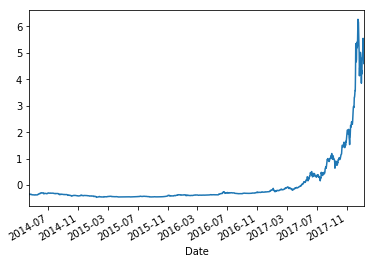

In [14]:
data['Mid'].plot()
